In [1]:
import sys
sys.path.append('../')
from datasets import load_dataset
from utils.data import split_data
import pandas as pd
import numpy as np
from utils.plotting import scatter
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsClassifier as Knn
from utils.pca import PCA


In [2]:
def test_knn_no_cross(data: pd.DataFrame, max_k, shuffle = False) -> list:
  if shuffle:
    data = data.sample(frac=1).reset_index(drop=True)
  train, test = split_data(data, (0.8, 0.2))
  result = [np.NAN]
  train_feature = train.loc[:, train.columns != 'class']
  test_feature = test.loc[:, test.columns != 'class']
  for i in range(1, max_k + 1):
    model = Knn(i)
    model.fit(train_feature, train["class"])
    prediction = model.predict(test_feature)
    result.append(np.mean(prediction == test["class"].values) )

  return result

In [3]:
def test_knn_k_fold(data: pd.DataFrame, k, fold, shuffle = False) -> float:
  if shuffle:
    data = data.sample(frac=1).reset_index(drop=True)

  subsets = split_data(data, [1 / fold for c in range(fold)])

  folds = []
  for i in range(fold):
    test = subsets[i]
    train = pd.concat((*subsets[:i], *subsets[i+1:]))

    train_feature = train.loc[:, train.columns != 'class']
    test_feature = test.loc[:, test.columns != 'class']

    model = Knn(k)
    model.fit(train_feature, train["class"])
    prediction = model.predict(test_feature)
    folds.append(np.mean(prediction == test["class"].values))

  return np.mean(folds)

In [4]:
def test_knn_leave_one_out(data: pd.DataFrame, k, shuffle=False) -> float:
  if shuffle:
    data = data.sample(frac=1).reset_index(drop=True)

  rows = len(data)
  result = []
  for i in range(rows):
    test = data[i: i+1]
    train = pd.concat((data[ : i], data[i+1: ]))
    train_feature = train.loc[:, train.columns != 'class']
    test_feature = test.loc[:, test.columns != 'class']
    model = Knn(k)
    model.fit(train_feature, train["class"])
    prediction = model.predict(test_feature)
    result.append(np.mean(prediction == test["class"].values))
  
  return np.mean(result)

In [5]:
iris_data, iris_features = load_dataset.iris(shuffle=True)
rice_data, rice_features = load_dataset.rice(shuffle=True)

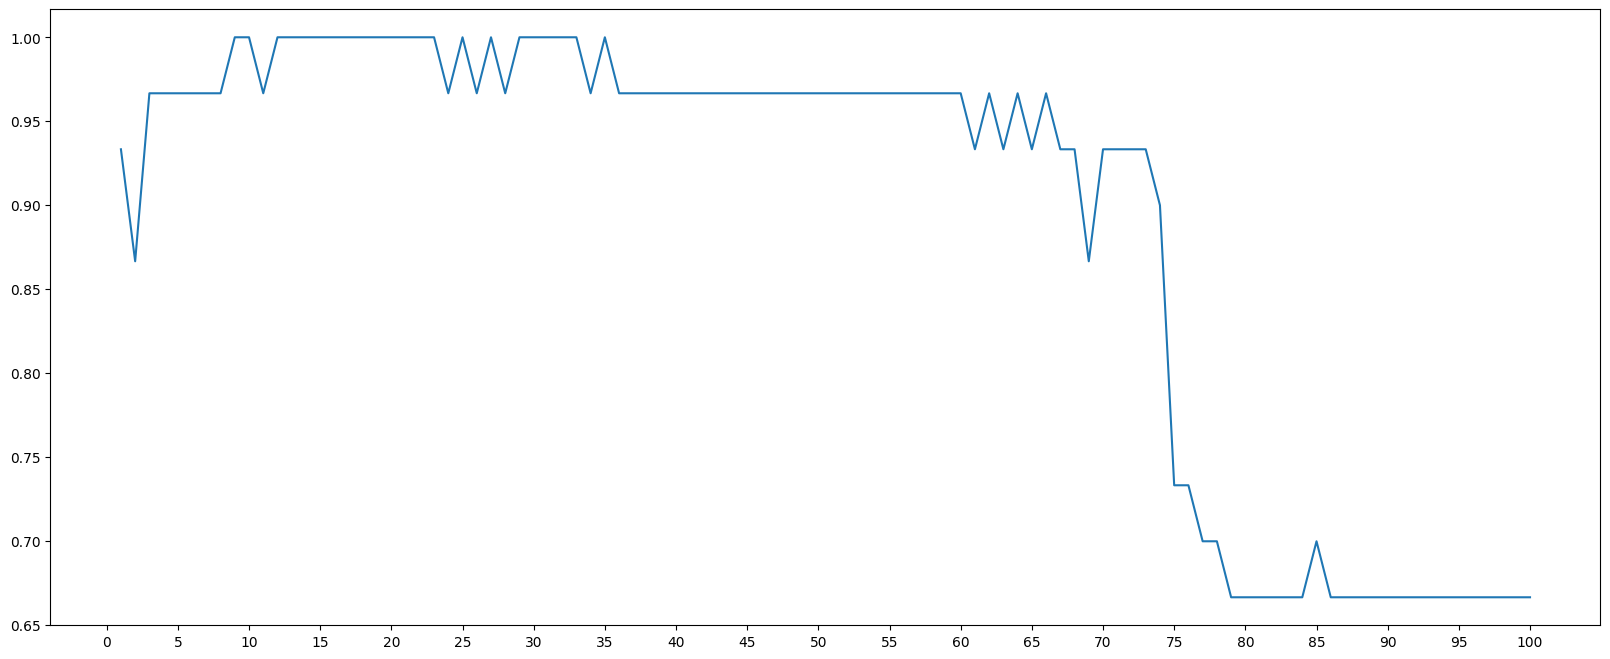

In [6]:
iris_performance = test_knn_no_cross(iris_data, 100)
plt.figure(figsize=(20, 8))
plt.xticks(np.arange(0, 101, 5))
plt.plot(iris_performance)

In [7]:
def gaussian_normalize(data: pd.DataFrame) -> pd.DataFrame:
  normalize_data = (data - data.mean()) / data.std()
  return normalize_data

def min_max_normalize(data: pd.DataFrame) -> pd.DataFrame:
  normalize_data = (data - data.min()) / (data.max() - data.min())
  return normalize_data

In [8]:
def with_class(data: pd.DataFrame, labels):
  new_data = data.copy()
  new_data["class"] = labels
  return new_data

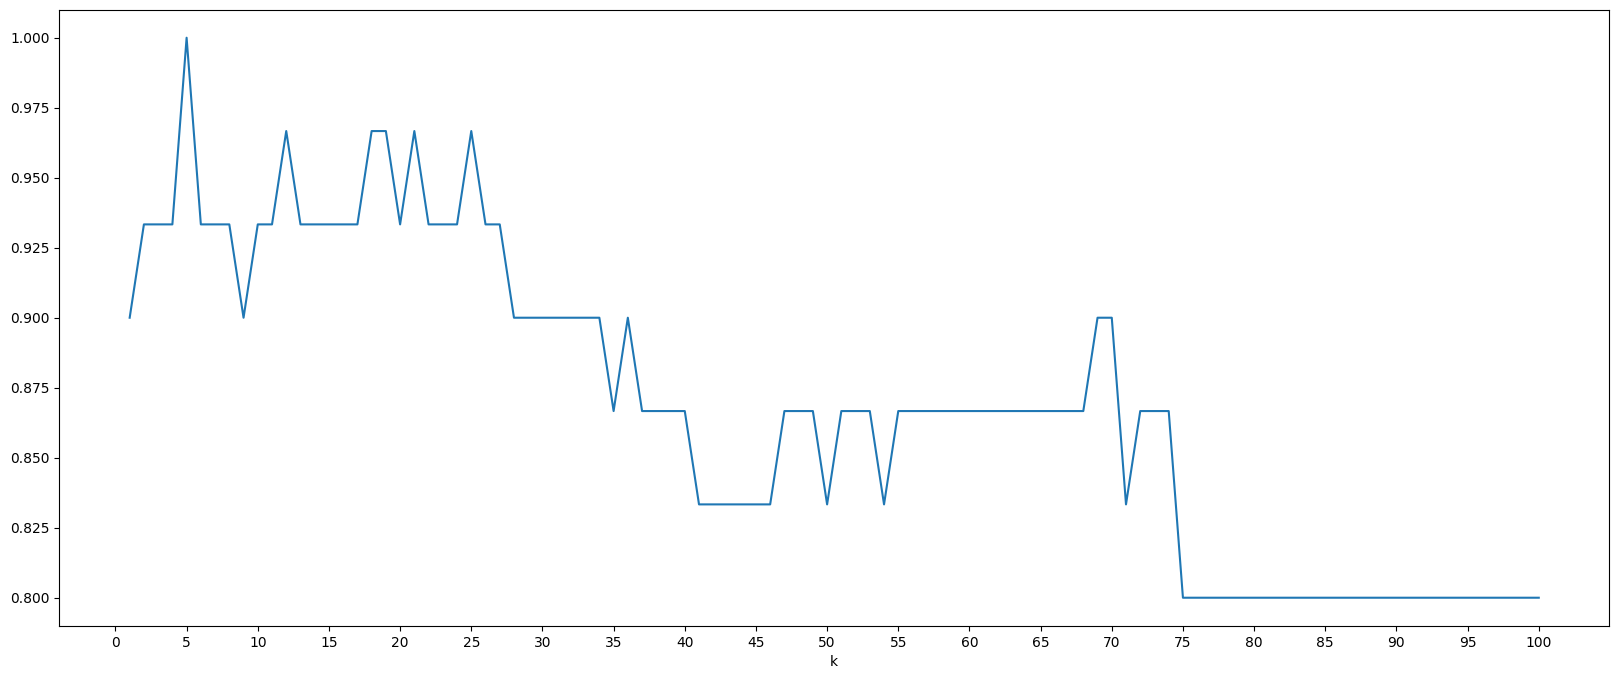

In [9]:
iris_gaussian_normalize = gaussian_normalize(iris_features)
iris_gaussian_normalize_performance = test_knn_no_cross(with_class(iris_gaussian_normalize, iris_data["class"]), 100)
plt.figure(figsize=(20, 8))
plt.xlabel("k")
plt.xticks(np.arange(0, 101, 5))
plt.plot(iris_gaussian_normalize_performance)

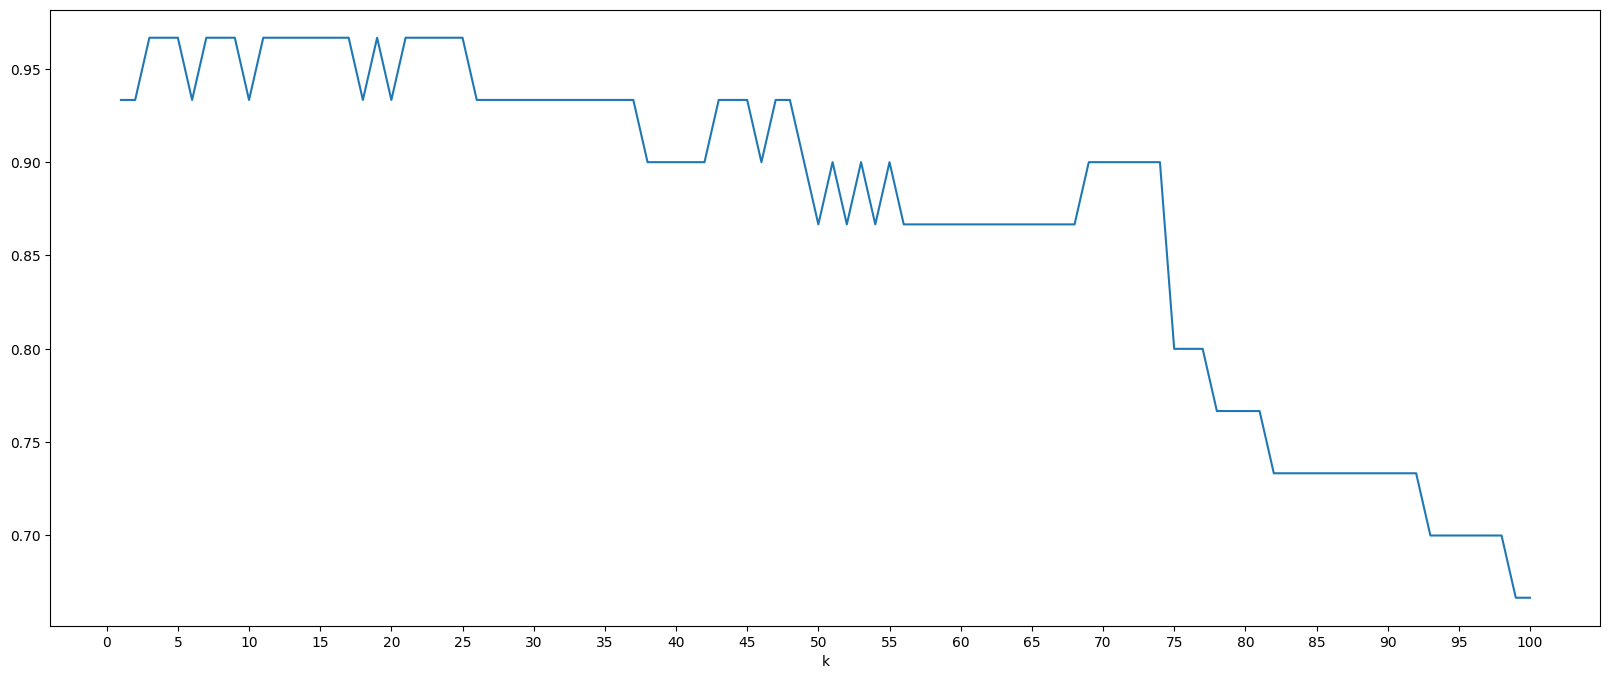

In [10]:
iris_min_max_normalize = min_max_normalize(iris_features)
iris_min_max_normalize_performance = test_knn_no_cross(with_class(iris_min_max_normalize, iris_data["class"]), 100)
plt.figure(figsize=(20, 8))
plt.xlabel("k")
plt.xticks(np.arange(0, 101, 5))
plt.plot(iris_min_max_normalize_performance)

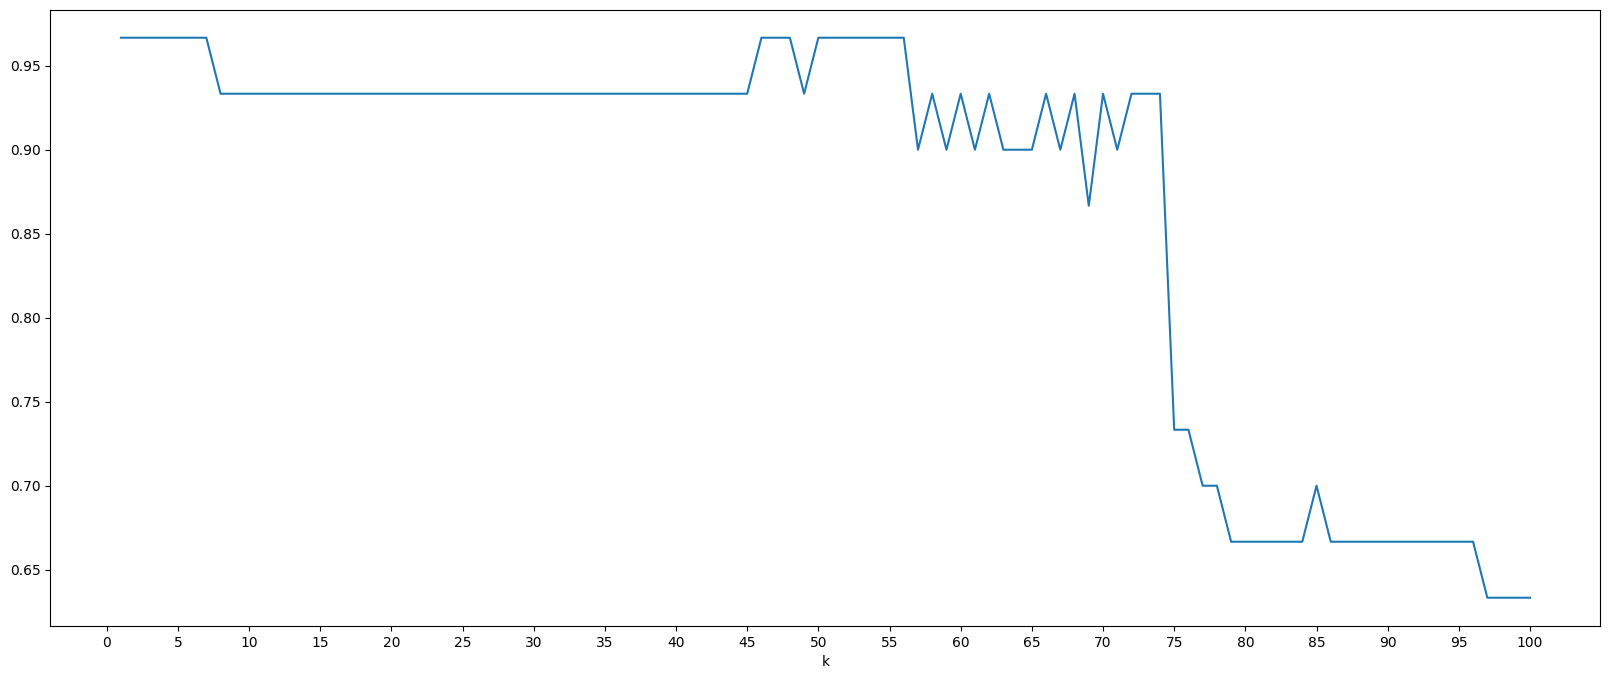

In [11]:
iris_pca = PCA(iris_features, iris_data["class"])
iris_pca_performance = test_knn_no_cross(iris_pca.project(2), 100)
plt.figure(figsize=(20, 8))
plt.xticks(np.arange(0, 101, 5))
plt.xlabel("k")
plt.plot(iris_pca_performance)

# K-fold

Text(0.5, 0, 'k')

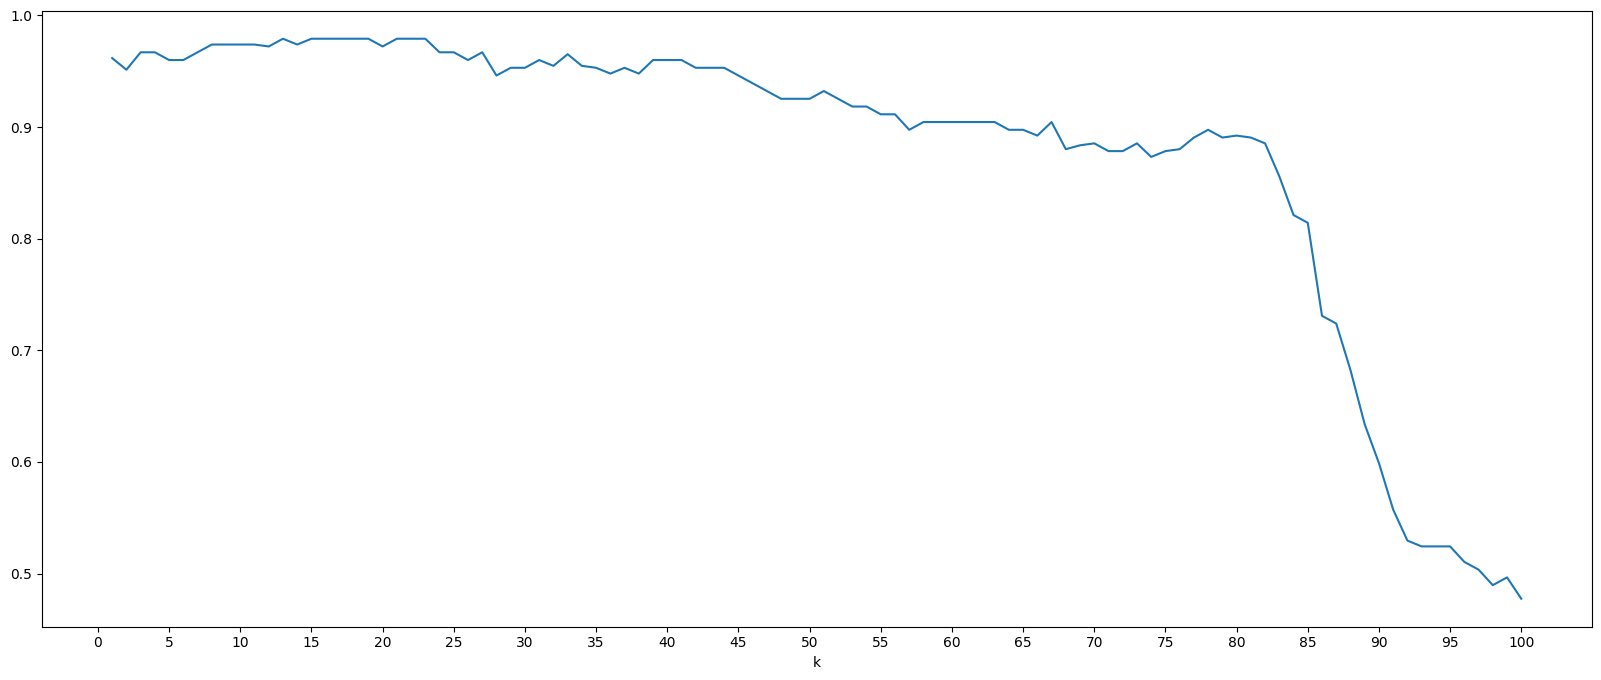

In [12]:
ks = [np.nan]
for k in range(1, 100 + 1):
  ks.append(test_knn_k_fold(iris_data, k, 8))

plt.figure(figsize=(20, 8))
plt.xticks(np.arange(0, 101, 5))
plt.plot(ks)
plt.xlabel("k")

Text(0.5, 0, 'no of folds')

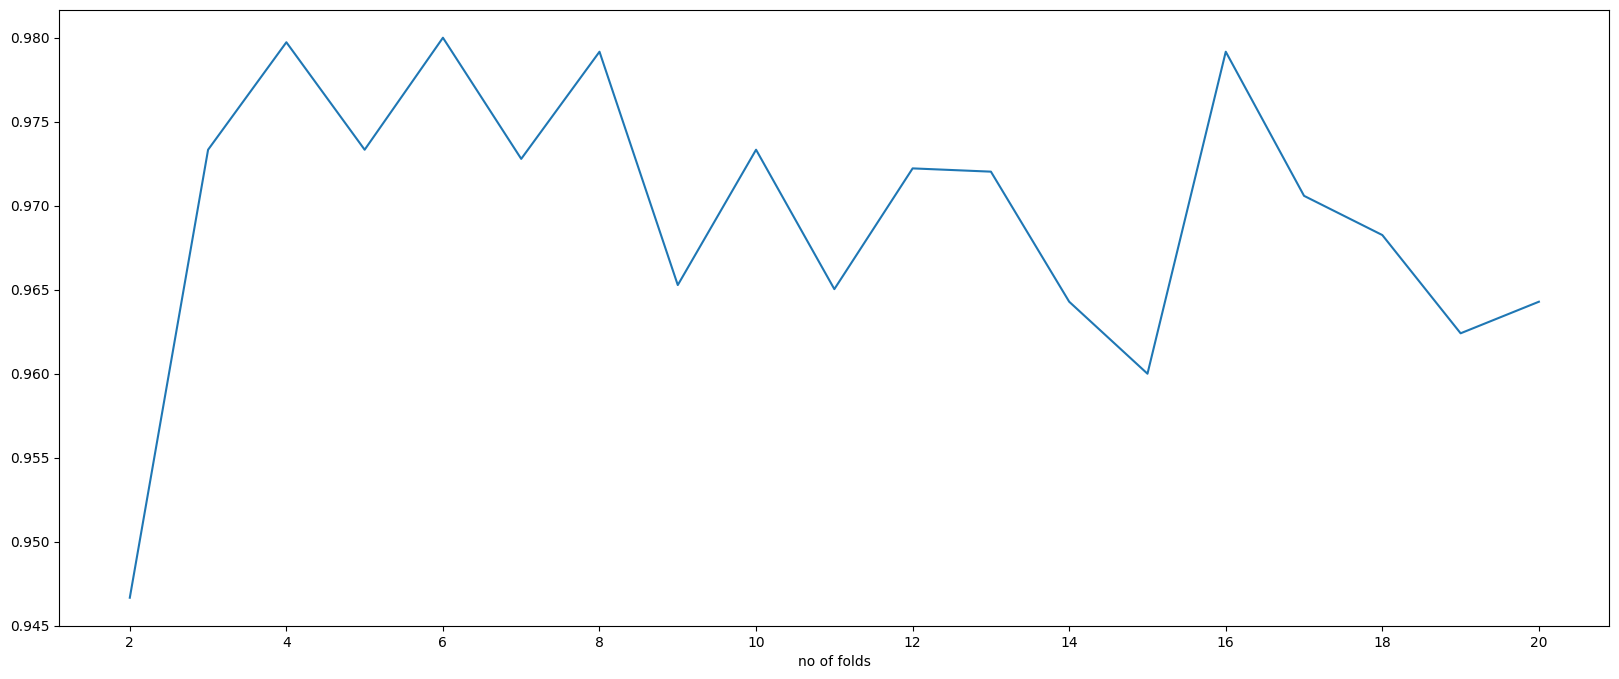

In [13]:
folds = [np.nan, np.nan]
for fold in range(2, 20 + 1):
  folds.append(test_knn_k_fold(iris_data, 16, fold))

plt.figure(figsize=(20, 8))
plt.xticks(np.arange(2, 40, 2))
plt.plot(folds)
plt.xlabel("no of folds")

# Leave one out

Text(0.5, 0, 'no of k')

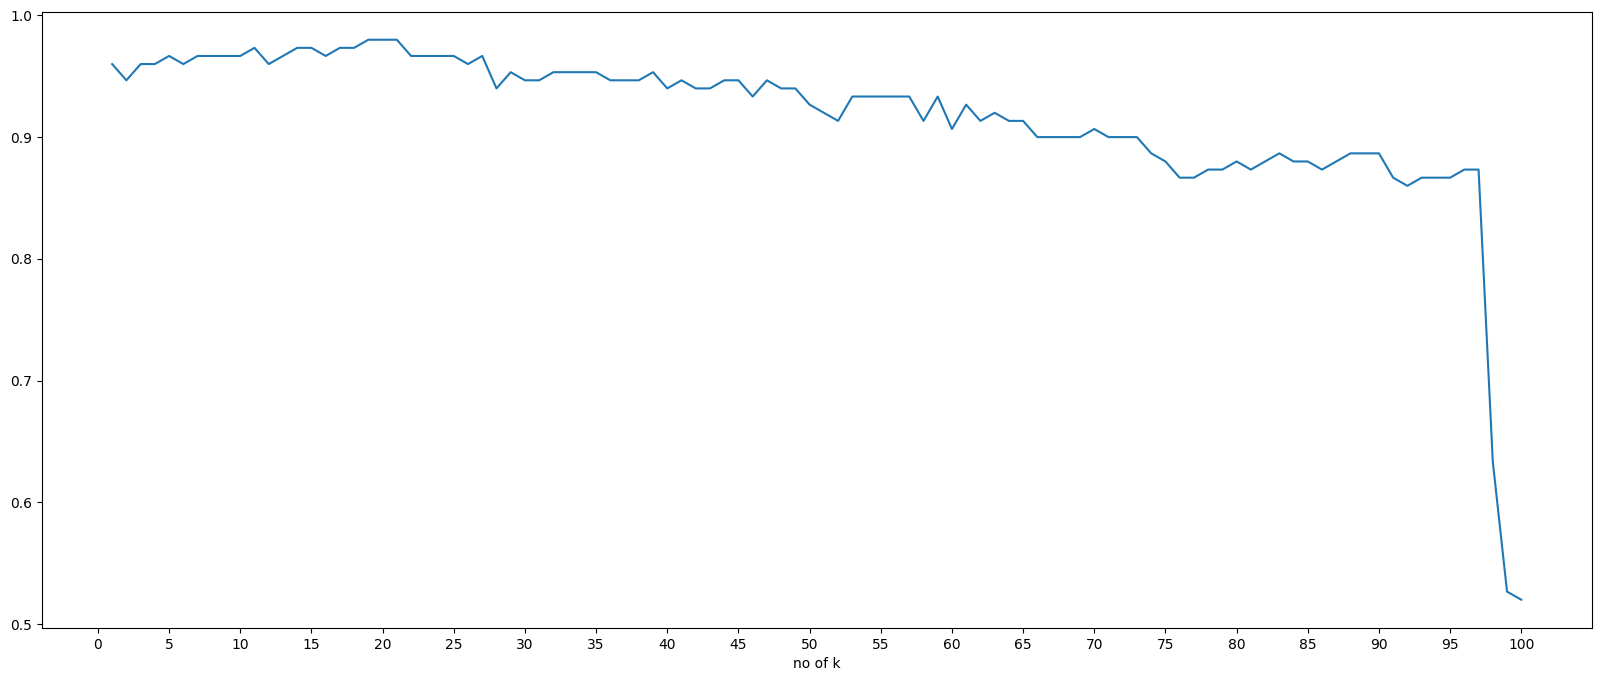

In [14]:
loo = []
for k in range(1, 100 + 1):
  loo.append(test_knn_leave_one_out(iris_data, k))

plt.figure(figsize=(20, 8))
plt.xticks(np.arange(0, 105, 5))
plt.plot([np.nan, *loo])
plt.xlabel("no of k")
